# Evapotranspiration Notebook

This notebook is being used to analyze evapotranspiration in the area surrounding Lake Malawi.

Based on https://planetarycomputer.microsoft.com/docs/quickstarts/reading-stac/#Analyzing-STAC-Metadata

## Notes

The planetary computer catalog uses signed URLs. If errors occur, re-run this notebook from the top to get new signatures. (The signatures expire)

In [1]:
from collections import defaultdict
import geopandas
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pystac_client
import planetary_computer
import rasterio
from rasterio.merge import merge
from rasterio.mask import mask
from rasterio.io import MemoryFile
from shapely.geometry import shape
from shapely.ops import transform
import pyproj
from pathlib import Path

In [2]:
# File helpers
def input_path(filename):
  return f"../data/raw/{filename}"

def output_path(filename):
  return f"../data/processed/{filename}"

In [3]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

In [4]:
SKIP_PROCESS_RAW = True

# Get Data

We are going to get data from the Modis 16A3GF-061 collection. See:

- https://planetarycomputer.microsoft.com/api/stac/v1/collections/modis-16A3GF-061
- https://planetarycomputer.microsoft.com/explore?c=25.1977%2C-5.0190&z=5.62&v=2&d=modis-16A3GF-061&m=Most+recent&r=Total+evapotranspiration+yearly+500m+%28kg%2Fm²%2Fyear%29&s=false%3A%3A100%3A%3Atrue&sr=desc&ae=0

In [61]:
time_range = "2017-01-01/2024-12-31"

with open(output_path("lake_malawi_expanded_25km.json"), 'r') as f:
    malawi_data = json.load(f)

area_of_interest = malawi_data["geometry"]

search = catalog.search(
    collections=["modis-16A3GF-061"], intersects=area_of_interest, datetime=time_range
)
items = search.item_collection()
len(items)

32

In [62]:
df = geopandas.GeoDataFrame.from_features(items.to_dict(), crs="epsg:4326")
df

,geometry,datetime,platform,instruments,end_datetime,modis:tile-id,start_datetime,modis:vertical-tile,modis:horizontal-tile,created,updated,proj:wkt2,proj:shape,proj:geometry,proj:transform
0,"POLYGON ((30.4628 -10, 30.59261 -11.29583, 30....",None,aqua,[modis],2024-12-31T23:59:59Z,51021010,2024-01-01T00:00:00Z,10,21,NaN,NaN,NaN,NaN,NaN,NaN
1,"POLYGON ((30 0, 30.00728 -1.2625, 30.02916 -2....",None,aqua,[modis],2024-12-31T23:59:59Z,51021009,2024-01-01T00:00:00Z,9,21,NaN,NaN,NaN,NaN,NaN,NaN
2,"POLYGON ((30.4628 -10, 30.59261 -11.29583, 30....",None,terra,[modis],2024-12-31T23:59:59Z,51021010,2024-01-01T00:00:00Z,10,21,NaN,NaN,NaN,NaN,NaN,NaN
3,"POLYGON ((30 0, 30.00728 -1.2625, 30.02916 -2....",None,terra,[modis],2024-12-31T23:59:59Z,51021009,2024-01-01T00:00:00Z,9,21,NaN,NaN,NaN,NaN,NaN,NaN
4,"POLYGON ((31.79884 -20.00992, 30.34848 -9.9655...",None,aqua,[modis],2023-12-31T23:59:59Z,51021010,2023-01-01T00:00:00Z,10,21,2024-02-09T22:00:03Z,2024-02-09T16:04:42.130000Z,"PROJCS[""unnamed"",GEOGCS[""Unknown datum based u...","[2400, 2400]","{'type': 'Polygon', 'coordinates': [[[4447802....","[463.3127165279167, 0.0, 3335851.559, 0.0, -46..."
5,"POLYGON ((30.34497 -10.00304, 29.88785 -3.8508...",None,aqua,[modis],2023-12-31T23:59:59Z,51021009,2023-01-01T00:00:00Z,9,21,2024-02-09T21:27:03Z,2024-02-09T15:33:30.558000Z,"PROJCS[""unnamed"",GEOGCS[""Unknown datum based u...","[2400, 2400]","{'type': 'Polygon', 'coordinates': [[[4447802....","[463.3127165279167, 0.0, 3335851.559, 0.0, -46..."
6,"POLYGON ((31.79884 -20.00992, 30.34848 -9.9655...",None,terra,[modis],2023-12-31T23:59:59Z,51021010,2023-01-01T00:00:00Z,10,21,2024-02-07T16:15:07Z,2024-02-07T13:01:12.098000Z,"PROJCS[""unnamed"",GEOGCS[""Unknown datum based u...","[2400, 2400]","{'type': 'Polygon', 'coordinates': [[[4447802....","[463.3127165279167, 0.0, 3335851.559, 0.0, -46..."
7,"POLYGON ((30.34497 -10.00304, 29.88785 -3.8508...",None,terra,[modis],2023-12-31T23:59:59Z,51021009,2023-01-01T00:00:00Z,9,21,2024-02-07T15:06:39Z,2024-02-07T13:01:01.584000Z,"PROJCS[""unnamed"",GEOGCS[""Unknown datum based u...","[2400, 2400]","{'type': 'Polygon', 'coordinates': [[[4447802....","[463.3127165279167, 0.0, 3335851.559, 0.0, -46..."
8,"POLYGON ((30.3485 -9.9655, 40.629 -9.9553, 42....",None,,[],2022-12-31T23:59:59Z,51021010,2022-01-01T00:00:00Z,10,21,2023-01-29T23:54:26Z,2023-05-17T00:12:24.351000Z,"PROJCS[""unnamed"",GEOGCS[""Unknown datum based u...","[2400, 2400]","{'type': 'Polygon', 'coordinates': [[[4447802....","[463.3127165279167, 0.0, 3335851.559, 0.0, -46..."
9,"POLYGON ((29.8879 0, 40.0119 0.0034, 40.624 -9...",None,,[],2022-12-31T23:59:59Z,51021009,2022-01-01T00:00:00Z,9,21,2023-01-29T23:54:17Z,2023-05-17T00:12:31.427000Z,"PROJCS[""unnamed"",GEOGCS[""Unknown datum based u...","[2400, 2400]","{'type': 'Polygon', 'coordinates': [[[4447802....","[463.3127165279167, 0.0, 3335851.559, 0.0, -46..."


Check the available assets

In [10]:
print(items[0].assets.keys())

dict_keys(['hdf', 'ET_500m', 'LE_500m', 'PET_500m', 'PLE_500m', 'ET_QC_500m', 'tilejson', 'rendered_preview'])


In [18]:
# Note: run this part in ICE or skip it and load the result directly in local
if not SKIP_PROCESS_RAW:
    items_by_year = defaultdict(list)
    for item in items:
        year = item.properties["start_datetime"][:4]
        items_by_year[year].append(item)
    
    et_data_by_year = {}
    
    years_list = []
    means = []
    mins = []
    maxs = []
    p25_list = []
    p75_list = []
    
    for year, year_items in items_by_year.items():
        print(f"Processing {year} with {len(year_items)} tiles...")
        
        datasets = []
        for item in year_items:
            et_asset = item.assets['ET_500m']
            et_href = et_asset.href
            datasets.append(rasterio.open(et_href))
        
        first_crs = datasets[0].crs
        first_nodata = datasets[0].nodata
        first_profile = datasets[0].profile.copy()
        
        merged_data, merged_transform = merge(datasets)
        
        for ds in datasets:
            ds.close()
        
        # Now mask to area of interest
        area_of_interest_shape = shape(area_of_interest)
        transformer = pyproj.Transformer.from_crs("EPSG:4326", first_crs, always_xy=True)
        area_of_interest_reprojected = transform(transformer.transform, area_of_interest_shape)
        
        # Create a temporary profile for masking
        temp_profile = first_profile
        temp_profile.update({
            'height': merged_data.shape[1],
            'width': merged_data.shape[2],
            'transform': merged_transform
        })
        
        # Mask the merged data with 25km area surrounding Lake Malawi
        from rasterio.io import MemoryFile
        with MemoryFile() as memfile:
            with memfile.open(**temp_profile) as mem_dataset:
                mem_dataset.write(merged_data)
                masked_data, masked_transform = mask(
                    mem_dataset,
                    [area_of_interest_reprojected],
                    crop=True,
                    nodata=first_nodata
                )
        
        et_data_by_year[year] = {
            'data': masked_data,
            'transform': masked_transform,
            'profile': temp_profile
        }
        
        flat_data = masked_data.flatten()
        valid_data = flat_data[flat_data != first_nodata]
    
        # Filter out unreasonably high values (MODIS is scaled to a valid integer of 0 to 32767)
        # See: https://mcst.gsfc.nasa.gov/l1b-algorithm-overview
        valid_data = valid_data[(valid_data >= 0) & (valid_data < 32767)]
    
        if len(valid_data) > 0:
            scaled_data = valid_data * 0.1
            print(f"{year}: Mean ET = {scaled_data.mean():.2f} kg/m²/year")
            years_list.append(int(year))
            means.append(scaled_data.mean())
            mins.append(scaled_data.min())
            maxs.append(scaled_data.max())
            p25_list.append(np.percentile(scaled_data, 25))
            p75_list.append(np.percentile(scaled_data, 75))
        else:
            print(f"{year}: No valid data")

In [19]:
if not SKIP_PROCESS_RAW:
    sorted_indices = np.argsort(years_list)
    years_sorted = np.array(years_list)[sorted_indices]
    means_sorted = np.array(means)[sorted_indices]
    mins_sorted = np.array(mins)[sorted_indices]
    maxs_sorted = np.array(maxs)[sorted_indices]
    p25_sorted = np.array(p25_list)[sorted_indices]
    p75_sorted = np.array(p75_list)[sorted_indices]
    
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(years_sorted, means_sorted, marker='o', label='Mean ET', linewidth=2, color='blue')
    ax.fill_between(years_sorted, mins_sorted, maxs_sorted, alpha=0.3, label='Min-Max Range')
    ax.fill_between(years_sorted, p25_sorted, p75_sorted, alpha=0.5, label="25th-75th Percentile Range")
    ax.set_xlabel('Year', fontsize=12)
    ax.set_ylabel('Evapotranspiration (kg/m²/year)', fontsize=12)
    ax.set_title('Evapotranspiration Over Time (2017-2024)', fontsize=14)
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [21]:
# Save generated ET stats to JSON for re-use
if not SKIP_PROCESS_RAW:
    et_output_path = output_path("../data/processed/et_stats.json")
    
    et_json_data = {}
    for i, year in enumerate(years_sorted):
        et_json_data[str(year)] = {
            "mean": float(means_sorted[i]),
            "min": float(mins_sorted[i]),
            "max": float(maxs_sorted[i]),
            "p25": float(p25_sorted[i]),
            "p75": float(p75_sorted[i])
        }
    
    with open(et_output_path, 'w') as f:
        json.dump(et_json_data, f, indent=2)
        
    print(f"ET stats saved to {et_output_path}")

## Align with Land Cover Data per Reoslution

In [69]:
def get_modis_block_at_latlon(items, lat, lon, asset_key='ET_500m', 
                               radius_pixels=1, scale_factor=0.1):
    """
    Get a block of MODIS pixels around a lat/lon (for averaging/comparison).
    
    Args:
        items: [pystac items]
        lat, lon: Center coordinate (WGS84)
        asset_key: MODIS asset key
        radius_pixels: Number of pixels around center (1 = 3x3 block = 1.5km x 1.5km)
        scale_factor: Scale factor to apply
    
    Returns:
        dict of {center, block_shape, stats, raw_data}
    """
    result = {}
    
    datasets = []
    for item in items:
        href = item.assets[asset_key].href
        datasets.append(rasterio.open(href))
    
    first_crs = datasets[0].crs
    first_nodata = datasets[0].nodata
    
    merged_data, merged_transform = merge(datasets)
    
    for ds in datasets:
        ds.close()
    
    transformer = pyproj.Transformer.from_crs("EPSG:4326", first_crs, always_xy=True)
    x, y = transformer.transform(lon, lat)
    
    inv_transform = ~merged_transform
    col_f, row_f = inv_transform * (x, y)
    center_row, center_col = int(row_f), int(col_f)
    
    r_start = max(0, center_row - radius_pixels)
    r_end = min(merged_data.shape[1], center_row + radius_pixels + 1)
    c_start = max(0, center_col - radius_pixels)
    c_end = min(merged_data.shape[2], center_col + radius_pixels + 1)
    
    block = merged_data[0, r_start:r_end, c_start:c_end]
    
    # Scale the entire block, replacing nodata/invalid with NaN
    scaled_block = block.astype(float)
    invalid_mask = (block == first_nodata) | (block < 0) | (block > 32700)
    scaled_block[invalid_mask] = np.nan
    scaled_block[~invalid_mask] *= scale_factor # for ET_500, use scale_factor=0.1 to convert to be  
    
    # Compute stats from valid (non-NaN) pixels
    valid = scaled_block[~np.isnan(scaled_block)]
    
    if len(valid) > 0:
        results = {
            'center': {'lat': lat, 'lon': lon},
            'block_shape': scaled_block.shape,
            'details': {'metric': 'ET_500m', 'unit': "kg/m²/year", 'stats':{
                'mean': float(valid.mean()),
                'std': float(valid.std()),
                'min': float(valid.min()),
                'max': float(valid.max()),
                'n_valid_pixels': int(len(valid)),
                'n_total_pixels': int(scaled_block.size)}
                       },
            'raw_data': scaled_block.tolist(),
        }
    else:
        result = {
            'center': {'lat': lat, 'lon': lon},
            'block_shape': scaled_block.shape,
            'stats': None,
            'raw_data': scaled_block.tolist(),
        }
    
    stats_summary = result['stats']
    print(f"{asset_key} block mean = {stats_summary['mean'] if stats_summary else 'No valid data'}")
    
    return result

In [5]:
time_range = "2024-01-01/2024-12-31"

with open(output_path("lake_malawi_expanded_25km.json"), 'r') as f:
    malawi_data = json.load(f)

area_of_interest = malawi_data["geometry"]

search = catalog.search(
    collections=["modis-16A3GF-061"], intersects=area_of_interest, datetime=time_range
)
items = search.item_collection()
len(items)

4

In [9]:
items[3]

<Item id=MOD16A3GF.A2024001.h21v09.061.2025019231440>

In [ ]:
result = get_modis_block_at_latlon(items, lat=-11.425259, lon=34.406701, radius_pixels=1) # e.g. water: (-11.425259, 34.406701), trees: (-11.489745, 34.108476)
print(f"Block shape: {result_year['block_shape']}")
print(f"Block details:")
for cls in result_year['details']:
    print(f" {cls['metric']}: {cls['stats']})")

# Visualize Landcover Change and Relationships with ET

In [25]:
import json
import pandas as pd

land_cover_stats_path = output_path("land_cover_stats.json")

with open(land_cover_stats_path, 'r') as f:
    land_cover_stats = json.load(f)

# Process into DataFrame
lc_data = []
color_map = {}

for year, data in land_cover_stats.items():
    row = {'Year': int(year)}
    for class_id, class_data in data['classes'].items():
        row[class_data['label']] = class_data['percentage']
        # Save color mapping
        if class_data['label'] not in color_map:
             color_map[class_data['label']] = class_data['color']
    lc_data.append(row)

lc_df = pd.DataFrame(lc_data).sort_values('Year').set_index('Year')
lc_df = lc_df.fillna(0) # Ensure no NaNs for missing classes

print("Land Cover DataFrame Head:")
print(lc_df.head())

Land Cover DataFrame Head:
      Water  Trees  Flooded  Crops  Built Area  Bare Ground  Clouds  Rangeland
Year                                                                          
2017  49.81  15.94     0.05   3.98        1.51         0.03    0.00      28.68
2018  49.83  18.61     0.09   3.75        1.72         0.02    0.01      25.97
2019  49.83  18.61     0.08   3.94        1.78         0.01    0.00      25.74
2020  49.87  16.89     0.14   4.35        1.79         0.01    0.00      26.95
2021  49.88  14.49     0.15   4.49        1.97         0.01    0.00      29.01


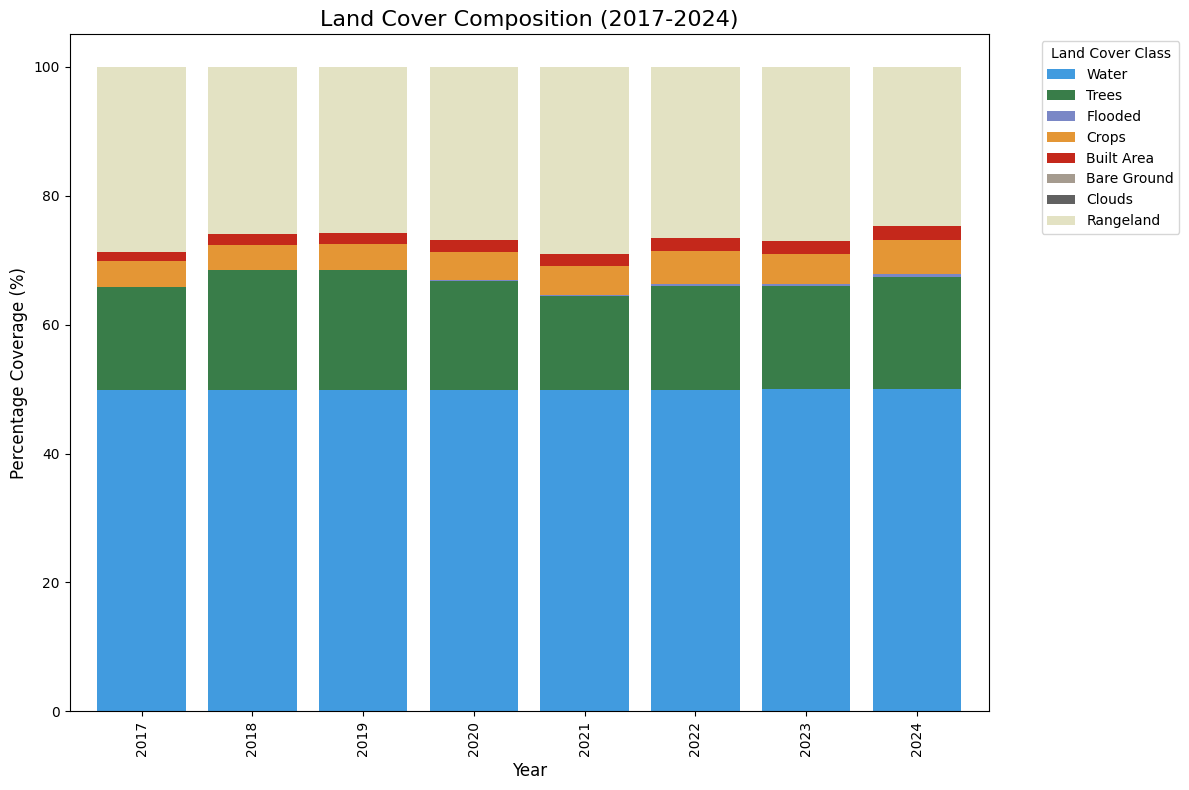

In [26]:
# Stacked bar chart for land cover change
columns = [c for c in lc_df.columns if c in color_map]

# Ensure we have colors for all columns in the correct order
colors = [color_map[c] for c in columns]

ax = lc_df[columns].plot(kind='bar', stacked=True, figsize=(12, 8), color=colors, width=0.8)

plt.title('Land Cover Composition (2017-2024)', fontsize=16)
plt.ylabel('Percentage Coverage (%)', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Land Cover Class")
plt.tight_layout()
plt.show()

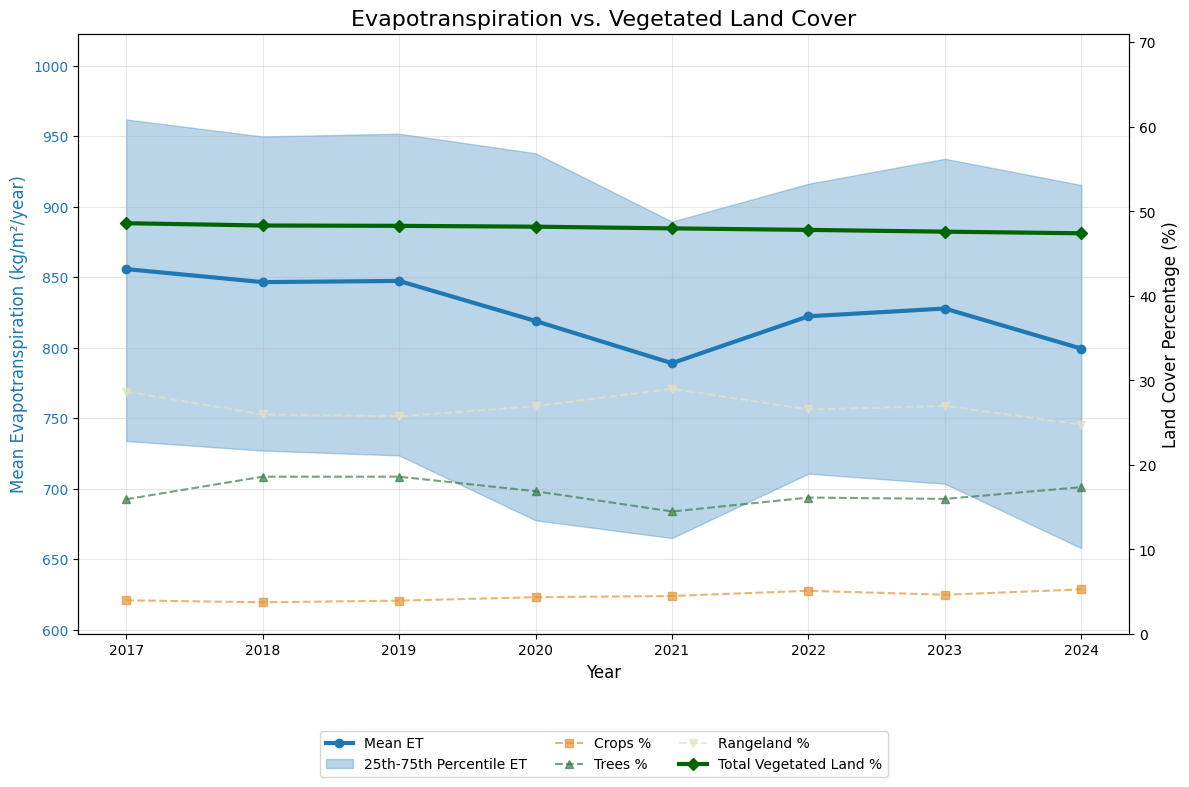

In [27]:
# Dual-axis line chart: evapotranspiration vs. vegetated land cover

# Load ET data from JSON
et_stats_path = output_path("et_stats.json")
with open(et_stats_path, 'r') as f:
    et_stats_data = json.load(f)

# Convert to DataFrame
et_years = sorted([int(y) for y in et_stats_data.keys()])
# Extract mean, p25, and p75 from the nested dictionary
et_means = [et_stats_data[str(y)]['mean'] for y in et_years]
et_p25 = [et_stats_data[str(y)]['p25'] for y in et_years]
et_p75 = [et_stats_data[str(y)]['p75'] for y in et_years]

et_df = pd.DataFrame({
    'Year': et_years, 
    'Mean_ET': et_means,
    'P25_ET': et_p25,
    'P75_ET': et_p75
}).set_index('Year')

# Combine with land cover DataFrame
combined = lc_df.join(et_df, how='inner')

# Calculate total vegetated land (crops + trees + rangeland)
veg_cols = [c for c in ['Crops', 'Trees', 'Rangeland'] if c in combined.columns]
if veg_cols:
    combined['Vegetated Land'] = combined[veg_cols].sum(axis=1)

fig, ax1 = plt.subplots(figsize=(12, 8))

# Function to calculate padded limits
def get_padded_limits(min_val, max_val, padding_factor=0.1):
    rng = max_val - min_val
    if rng == 0: rng = abs(min_val) * 0.1 if min_val != 0 else 1.0
    return min_val - (rng * padding_factor), max_val + (rng * padding_factor)

# Plot mean ET and percentile range on left y-axis
color_et = 'tab:blue'
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Mean Evapotranspiration (kg/m²/year)', color=color_et, fontsize=12)

# Plot the range first so it's behind the line
fill_1 = ax1.fill_between(combined.index, combined['P25_ET'], combined['P75_ET'], 
                 alpha=0.3, color=color_et, label='25th-75th Percentile ET')

line1 = ax1.plot(combined.index, combined['Mean_ET'], color=color_et, marker='o', linewidth=3, label='Mean ET')

ax1.tick_params(axis='y', labelcolor=color_et)
ax1.grid(True, alpha=0.3)

# Apply padding to ET axis considering the full range (p25 to p75)
et_min_val = combined['P25_ET'].min()
et_max_val = combined['P75_ET'].max()
et_min_limit, et_max_limit = get_padded_limits(et_min_val, et_max_val, padding_factor=0.2)
ax1.set_ylim(et_min_limit, et_max_limit)

# Create right y-axis for land cover percentages
ax2 = ax1.twinx()

# Plot key vegetation classes
# Combine handles for legend: line1 is a list of lines, fill_1 is a PolyCollection
lines = line1 + [fill_1] 
plot_lc_cols = []

# Individual classes
if 'Crops' in combined.columns:
    color_crops = color_map.get('Crops', 'orange')
    line_crops = ax2.plot(combined.index, combined['Crops'], color=color_crops, marker='s', linestyle='--', linewidth=1.5, alpha=0.7, label='Crops %')
    lines += line_crops
    plot_lc_cols.append('Crops')

if 'Trees' in combined.columns:
    color_trees = color_map.get('Trees', 'green')
    line_trees = ax2.plot(combined.index, combined['Trees'], color=color_trees, marker='^', linestyle='--', linewidth=1.5, alpha=0.7, label='Trees %')
    lines += line_trees
    plot_lc_cols.append('Trees')

if 'Rangeland' in combined.columns:
    color_range = color_map.get('Rangeland', '#e3e2c3') 
    line_range = ax2.plot(combined.index, combined['Rangeland'], color=color_range, marker='v', linestyle='--', linewidth=1.5, alpha=0.7, label='Rangeland %')
    lines += line_range
    plot_lc_cols.append('Rangeland')

# Plot total vegetated land
if 'Vegetated Land' in combined.columns:
    line_veg = ax2.plot(combined.index, combined['Vegetated Land'], color='darkgreen', marker='D', linestyle='-', linewidth=3, label='Total Vegetated Land %')
    lines += line_veg
    plot_lc_cols.append('Vegetated Land')

# Apply padding to land cover axis based on all plotted columns
if plot_lc_cols:
    all_lc_values = combined[plot_lc_cols].values
    lc_min_val = all_lc_values.min()
    lc_max_val = all_lc_values.max()
    lc_min_limit, lc_max_limit = get_padded_limits(lc_min_val, lc_max_val, padding_factor=0.5) 
    lc_min_limit = max(0, lc_min_limit) if lc_min_val >= 0 else lc_min_limit
    ax2.set_ylim(lc_min_limit, lc_max_limit)

ax2.set_ylabel('Land Cover Percentage (%)', color='black', fontsize=12)
ax2.tick_params(axis='y', labelcolor='black')

# Combined legend
labels = [l.get_label() for l in lines]
# Place legend below the plot to avoid title overlap. Adjusted bbox and ncol for better fit.
ax1.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)

plt.title('Evapotranspiration vs. Vegetated Land Cover', fontsize=16)
plt.tight_layout()
plt.show()

# Conclusion: 
# Basially the mean ET has gradually decreased from 2017 to 2024, with some fluctuations during 2019 to 2022, which has negative
# correlation with the graduate increasing of crop and postivie correlction with the graduate decreasing of total vegetated land (a sum of crops, trees, and rangeland).
# There's also an obvious oppoisite change between trees and rangeland which indicates a potential subsitution for each other during the development period.
# Note that we did not calculate exact statistics like pearson-correlation as there are only 8 annual data points which is too few to compare.